Import Requirements

In [1]:
import os
import random

import cv2
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

Set the Hyperparameters

In [15]:
model_name = "efficientnet_b4"
weights = None #"imagenet"
input_dims = (128, 128, 3)
num_classes = 101
epochs = 250
batch_size = 64
shuffle_size = 16
learning_rate = 0.01
precision = "float32" #"mixed_float16"
model_dir = "models"
testing_set = 0.15

In [4]:
policy = tf.keras.mixed_precision.Policy(precision)
tf.keras.mixed_precision.set_global_policy(policy)

Create the EfficientNet Model

In [3]:
dropout = 0.2
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

In [4]:
models = {
    'efficientnet_b0': tf.keras.applications.EfficientNetB0,
    'efficientnet_b1': tf.keras.applications.EfficientNetB1,
    'efficientnet_b2': tf.keras.applications.EfficientNetB2,
    'efficientnet_b3': tf.keras.applications.EfficientNetB3,
    'efficientnet_b4': tf.keras.applications.EfficientNetB4,
    'efficientnet_b5': tf.keras.applications.EfficientNetB5,
    'efficientnet_b6': tf.keras.applications.EfficientNetB6,
    'efficientnet_b7': tf.keras.applications.EfficientNetB7
}
inputs = tf.keras.Input(shape=input_dims)
backbone = models[model_name](include_top=False,
                              weights=weights,
                              input_shape=input_dims,
                              classes=num_classes)(inputs)
backbone.trainable = True
# Output Arch
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(backbone)
x = tf.keras.layers.Dropout(dropout, name='top_dropout')(x)
output = tf.keras.layers.Dense(
    num_classes,
    activation="softmax",
    kernel_initializer=DENSE_KERNEL_INITIALIZER,
    name="predictions",
    dtype="float32")(x)
model = tf.keras.Model(inputs=inputs, outputs=output, name=model_name)

In [5]:
model.summary()

Model: "efficientnet_b4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 4, 4, 1792)       17673823  
                                                                 
 avg_pool (GlobalAveragePool  (None, 1792)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1792)              0         
                                                                 
 predictions (Dense)         (None, 101)               181093    
                                                                 
Total params: 17,854,916
Trainable params: 17,729,709
Non-trainable params: 125,207
_________________________________

Import training data (CIFAR-10)

In [7]:
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
"""

'\n(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()\nprint(x_train.shape)\nprint(y_train.shape)\n'

Import Real Training Data

In [5]:
x_train = []
y_train = []
labels_list = []

labels = os.listdir("data")
label_cn = 0
for label in labels:
    images_in_labels = os.listdir("data/" + label)
    for image in images_in_labels:
        labels_list.append(image)
        sub_images = os.path.join("data", label, image)
        for _t in os.listdir(sub_images):
            try:
                if _t.endswith(".jpg") or _t.endswith(".png") or _t.endswith(".jpeg"):
                    im = np.array(
                            cv2.imread(
                                os.path.join(sub_images, _t)))
                    if len(im.shape) == 3:
                        x_train.append(im)
                        y_train.append(int(label))
            except:
                pass
    label_cn += 1

Preprocessing

In [6]:
def augment_preprocess(image):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (input_dims[0], input_dims[1]))
    return image

def one_hot(indicies):
    return tf.one_hot(indicies, num_classes)[0]

In [7]:
# Load the data into RAM for extremely fast training
x_list = [augment_preprocess(image) for image in x_train]
y_list = [one_hot([label]) for label in y_train]

combined = list(zip(x_list, y_list))
print(len(combined))
random.shuffle(combined)
x_list, y_list = zip(*combined)

x_list = list(x_list)
y_list = list(y_list)

10131


In [8]:
test_split = int(len(x_list) * (1-testing_set))

x_training = np.array(x_list[:test_split])
y_training = np.array(y_list[:test_split])

x_testing = np.array(x_list[test_split:len(x_list)])
y_testing = np.array(y_list[test_split:len(x_list)])

In [9]:
print(test_split)
print(len(x_training))

8611
8611


In [11]:
print("Training image shapes " + str(x_training.shape))
print("Training label shapes " + str(y_training.shape))

print("Testing image shapes " + str(x_testing.shape))

print("Training set size " + str(len(x_training)))

Training image shapes (8611, 128, 128, 3)
Training label shapes (8611, 101)
Testing image shapes (1520, 128, 128, 3)
Training set size 8611


Datagenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rotation_range=20,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.3, 1.0], # brightness
                                   height_shift_range=0.2,  # vertical shift
                                   #vertical_flip = True,
                                   shear_range = 0.2)  

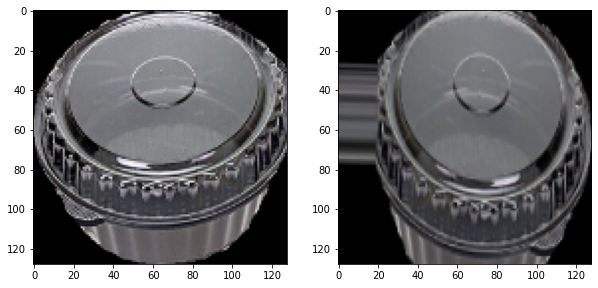

In [14]:
# View the original and augmented images
image = x_training[2229]
aug_image = train_datagen.random_transform(image)/255
figure = plt.figure(figsize=(10, 10))
figure.add_subplot(1, 2, 1)
plt.imshow(image)
figure.add_subplot(1, 2, 2)
plt.imshow(aug_image)
plt.show()

Training Settings

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [13]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join(model_dir, model_name, "tensorboard"),
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None)
learning_rate_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

Training

In [16]:
model.compile(optimizer=optimizer, loss=loss_func, metrics=["accuracy", "categorical_crossentropy"])
model.fit(train_datagen.flow(x_training, y_training, batch_size=batch_size), epochs=epochs, shuffle=True, callbacks=[tensorboard_cb, learning_rate_cb], validation_data=(x_testing, y_testing))

Epoch 1/250
135/135 [==============================] - 109s 656ms/step - loss: 4.7958 - accuracy: 0.0598 - categorical_crossentropy: 4.7958 - val_loss: 156.1922 - val_accuracy: 0.0842 - val_categorical_crossentropy: 156.1922 - lr: 0.0100
Epoch 2/250
135/135 [==============================] - 84s 619ms/step - loss: 4.1448 - accuracy: 0.0641 - categorical_crossentropy: 4.1448 - val_loss: 26.7066 - val_accuracy: 0.0783 - val_categorical_crossentropy: 26.7066 - lr: 0.0100
Epoch 3/250
135/135 [==============================] - 84s 621ms/step - loss: 3.9410 - accuracy: 0.0783 - categorical_crossentropy: 3.9410 - val_loss: 3.8962 - val_accuracy: 0.0895 - val_categorical_crossentropy: 3.8962 - lr: 0.0100
Epoch 4/250
135/135 [==============================] - 84s 622ms/step - loss: 3.8839 - accuracy: 0.0821 - categorical_crossentropy: 3.8839 - val_loss: 7.8752 - val_accuracy: 0.0388 - val_categorical_crossentropy: 7.8752 - lr: 0.0100
Epoch 5/250
135/135 [==============================] - 84s 62

In [20]:
tf.keras.models.save_model(model, os.path.join(model_dir, model_name, "model_FRANK"))

INFO:tensorflow:Assets written to: models\efficientnet_b4\model_FRANK\assets


INFO:tensorflow:Assets written to: models\efficientnet_b4\model_FRANK\assets


Testing

In [18]:
model.evaluate(x_testing, y_testing, batch_size=batch_size)

24/24 [==============================] - 4s 167ms/step - loss: 1.8884 - accuracy: 0.7230 - categorical_crossentropy: 1.8884


[1.8883721828460693, 0.7230263352394104, 1.8883721828460693]

Visual Testing

In [30]:
def bgremove1(myimage):
 
    # Blur to image to reduce noise
    myimage = cv2.GaussianBlur(myimage,(5,5), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv2.threshold(myimage_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv2.threshold(myimage_grey,0,255,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
 
    return finalimage

In [37]:
def bgremove3(myimage):
    # BG Remover 3
    myimage_hsv = cv2.cvtColor(myimage, cv2.COLOR_BGR2HSV)
        
    #Take S and remove any value that is less than half
    s = myimage_hsv[:,:,1]
    s = np.where(s < 127, 0, 1) # Any value below 127 will be excluded

    # We increase the brightness of the image and then mod by 255
    v = (myimage_hsv[:,:,2] + 127) % 255
    v = np.where(v > 127, 1, 0)  # Any value above 127 will be part of our mask

    # Combine our two masks based on S and V into a single "Foreground"
    foreground = np.where(s+v > 0, 1, 0).astype(np.uint8)  #Casting back into 8bit integer

    background = np.where(foreground==0,255,0).astype(np.uint8) # Invert foreground to get background in uint8
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)  # Convert background back into BGR space
    foreground=cv2.bitwise_and(myimage,myimage,mask=foreground) # Apply our foreground map to original image
    finalimage = background+foreground # Combine foreground and background
    return finalimage
def bgremove2(myimage):
# First Convert to Grayscale
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)

    ret,baseline = cv2.threshold(myimage_grey,127,255,cv2.THRESH_TRUNC)

    ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)

    ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)

    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground

    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)

    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground

    return finalimage

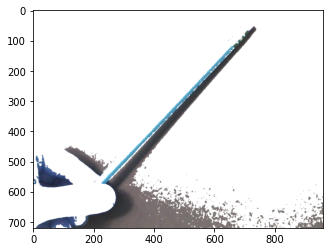

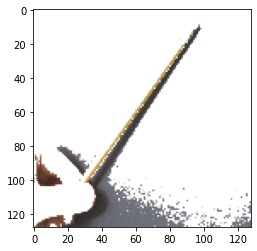

shreddedPaper


In [39]:

import cv2

# load model
model = tf.keras.models.load_model(os.path.join(model_dir, model_name, "model_FRANKb4"))
'''

pic = cv2.imread(pic)
# convert to RGB
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
pic = cv2.resize(pic, (input_dims[0], input_dims[1]))
plt.imshow(pic)
plt.show()
pred_index = tf.math.argmax(tf.squeeze(model(tf.expand_dims(pic, axis=0), training=False), axis=0))
prediction = labels_list[pred_index-1]
print(prediction)

# print confidence
prediction_prob = model.predict(tf.expand_dims(pic, axis=0))
print(prediction_prob)'''

'''pic = "C:/Users/Frank/Downloads/WIN_20220901_16_57_04_Pro-removebg-preview.png"
pic = cv2.imread(pic)
# convert to RGB
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
#pic = cv2.resize(pic, (input_dims[0], input_dims[1]))

scale_percent = 30 # percent of original size
width = int(pic.shape[1] * scale_percent / 100)
height = int(pic.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
resized = cv2.resize(pic, dim, interpolation = cv2.INTER_AREA)

y=0
x=20
h=128
w=128
pic = resized[y:y+h, x:x+w]
plt.imshow(pic)
plt.show()
pred_index = tf.math.argmax(tf.squeeze(model(tf.expand_dims(pic, axis=0), training=False), axis=0))
prediction = labels_list[pred_index-1]
print(prediction)'''

'''
# display images for index 0 - 9
for i in range(10):

test_index = 10
plt.imshow(x_training[test_index])
plt.show()
pred_index = tf.math.argmax(tf.squeeze(model(tf.expand_dims(x_training[test_index], axis=0), training=False), axis=0))
prediction = labels_list[pred_index-1]
print(prediction)

'''

#pic = "D:/plaste_cup (1).jpeg"
pic = "C:/Users/Frank/Pictures/Camera Roll/WIN_20220906_15_51_34_Pro.jpg"
pic = cv2.imread(pic)
pic = bgremove3(pic)
plt.imshow(pic)
plt.show()
# convert to RGB
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
pic = cv2.resize(pic, (input_dims[0], input_dims[1]))
#pic = bgremove1(pic)
plt.imshow(pic)
plt.show()
pred_index = tf.math.argmax(tf.squeeze(model(tf.expand_dims(pic, axis=0), training=False), axis=0))
prediction = labels_list[pred_index-1]
print(prediction)



In [ ]:
print(labels_list)

['plasticBag', 'dirtyBag', 'helmet', 'plasticCup', 'paperCup', 'styroCup', 'paperBento', 'receipt', 'chipBag', 'rubberBand', 'chipCan', 'pizzaBox', 'rainCoat', 'porcelain', 'portablePaperBag', 'comb', 'soapDispenser', 'mask', 'trashBag', 'plasticSpoon', 'eggCarton', 'pen', 'plushToy', 'facialCleanser', 'onionBag', 'chargingCable', 'pottedPlants', 'yakult', 'advertisingFlyer', 'transparentContainer', 'wood', 'lunchTray', 'creamers', 'yogaMat', 'toiletBrush', 'paperDiapers', 'fruitNet', 'milkCarton', 'disposableChopsticks', 'waterFilter', 'headphones', 'phoneCase', 'mirror', 'bubbleWrap', 'shreddedPaper', 'shoe', 'foamPeanuts', 'coatHanger', 'pencil', 'newspaper', 'hotCoffeeCup', 'boosterPack', 'spoutBag', 'snackPaperBag', 'aluminumFoil', 'quiltPillow', 'plasticStraw', 'wasteMedicine', 'instantNoodleBowl', 'glassBottle', 'whiteout', 'toy', 'staple', 'capsuleCoffee', 'coffeePod', 'cottonSwab', 'lighter', 'shatteredGlass', 'toiletPaperPackaging', 'milkPowderCan', 'contactLenses', 'cardboar